#### QUICKSTART

NOTE: conda install ffmpeg, if you can't visualize video with pymedia.

In [1]:
import mujoco
import mediapy as media
import os
import numpy as np

""

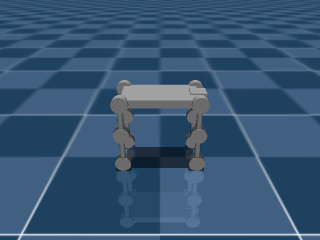

In [2]:
# Load model, see how it looks

mj_model = mujoco.MjModel.from_xml_path(os.path.join(os.getcwd(), "output_xmls", "basic_connieped.xml"))

mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, "base")
media.show_image(renderer.render())

""

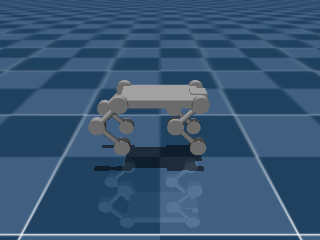

In [3]:
# Set the pose by joint name

hip_angle = -np.pi/4
shank_angle = -hip_angle * 2
quads = ["RF", "LF", "RH", "LH"]
for q in quads:
    mj_data.joint("{}_HJ".format(q)).qpos = hip_angle
    mj_data.joint("{}_KJ".format(q)).qpos = shank_angle

mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, "base")
media.show_image(renderer.render())

""

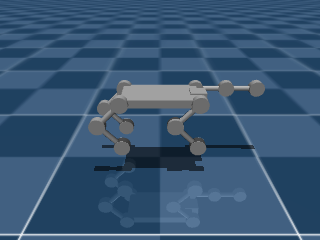

In [4]:
# You can also set the pose by joint index. 
# qpos is an 15-element vector with qpos[7:] corresponding to joint angles.
# The ordering for these is by quadrants (["RF", "LF", "RH", "LH"]). Within each quadrant, it's hip then thigh.
mj_data.qpos[7] = np.pi/2
mj_data.qpos[8] = 0
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, "base")
media.show_image(renderer.render())

In [6]:
# You can get back to this default pose using the "keyframe" that I saved in the xml file:
mujoco.mj_resetData(mj_model, mj_data) 
mj_data.qpos = mj_model.keyframe('standing').qpos
mj_data.qvel = np.zeros(mj_model.nv)
mj_data.ctrl = mj_model.keyframe('standing').ctrl

# Now, simulate the robot for 2 seconds. 
# Notes: 
# 1. simulating is *much* faster than rendering.
# 2. this is an example of *position* control: if you set ctrl[i] = theta, then the ith motor tries to move joint i to theta.  

duration = 2  # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []

while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if mj_data.time > 1:
    mj_data.ctrl = np.zeros(8)

  # RENDER
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, "base")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)
save_path = os.path.join(os.getcwd(),"outputs", "standing_still.gif")
media.write_video(save_path, frames, fps=framerate, codec="gif")

#### Fixed Velocity

In [2]:
import mujoco
import mediapy as media
import os
import numpy as np

""

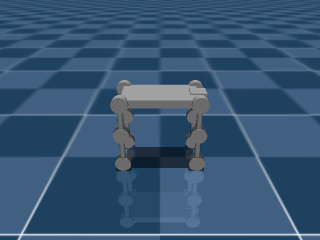

In [3]:
mj_model = mujoco.MjModel.from_xml_path(os.path.join(os.getcwd(), "output_xmls", "basic_connieped_fixed_v.xml"))

mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, "base")
media.show_image(renderer.render())

In [12]:
mujoco.mj_resetData(mj_model, mj_data) 
mj_data.qvel = np.zeros(mj_model.nv)
mj_data.ctrl = mj_model.keyframe('standing').ctrl

duration = 2  # (seconds)
framerate = 30  # (Hz)

# Simulate robot going down then up and display video.
frames = []

CW = -1
CCW = -1*CW*2

quads = ["RF", "LF", "RH", "LH"]

going_down = np.zeros(8)
going_up = np.zeros(8)

for i_q in range(np.size(quads)):
    going_down[i_q*2] = CW # Hips
    going_down[i_q*2+1] = CCW # Knees

    going_up[i_q*2] = -CW
    going_up[i_q*2+1] = -CCW

mj_data.ctrl = going_down

while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if mj_data.time > 1:
    mj_data.ctrl = going_up

  # RENDER
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, "base")
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)
save_path = os.path.join(os.getcwd(),"outputs", "standing_still.gif")
media.write_video(save_path, frames, fps=framerate, codec="gif")

#### MJX-Compatible

All geoms are now spheres, including the wheels.

MJX is 3x slower than equivalent Mujoco model in the first section.

#### Simulation Stability:

iterations, ls_iterations: (5,6) works. (1,4) doesn't.

In [1]:
import mujoco
import mediapy as media
import os
import numpy as np
from mujoco import mjx
from jax import numpy as jp
import jax 

""

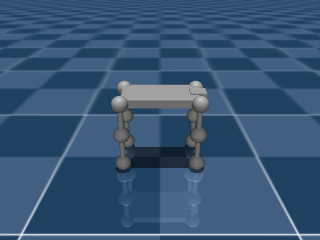

In [2]:
mj_model = mujoco.MjModel.from_xml_path(os.path.join(os.getcwd(), "output_xmls", "basic_connieped_mjx.xml"))

mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, "base")
media.show_image(renderer.render())

In [3]:
# Sim time: 1.2 min to jit compile, 4.1s afterwards. Vs 1.4s on the non-MJX version in the first section. 

mujoco.mj_resetData(mj_model, mj_data)
mj_data.qvel = np.zeros(mj_model.nv)
mj_data.ctrl = mj_model.keyframe('standing').ctrl
mj_data.qpos = mj_model.keyframe('standing').qpos

mujoco.mj_forward(mj_model, mj_data) # Doen't advance mj_data.time.

mjx_model = mjx.device_put(mj_model)
mjx_data = mjx.device_put(mj_data)

jstep = jax.jit(mjx.step)


# Runtime: this MJX code takes 1.2 min, ___ w/o warmup. Vs 17s on Mujoco. 
duration = 2  # (seconds)
framerate = 30  # (Hz)

frames = [] 

while mjx_data.time < duration:
  mjx_data = jstep(mjx_model, mjx_data)

  if mjx_data.time > 1:
    mjx_data = mjx_data.replace(ctrl=jp.zeros(8))
  # RENDER
  if len(frames) < mjx_data.time * framerate:
    # Load to CPU
    mjx.device_get_into(mj_data, mjx_data)
    mujoco.mj_forward(mj_model, mj_data)
    renderer.update_scene(mj_data, "base")
    pixels = renderer.render()
    frames.append(pixels)

In [4]:
media.show_video(frames, fps=framerate)

#### APPENDIX
##### WHEELS
The wheels can easily be unlocked and added as 4 separate control inputs. Reach to me out for how!

##### CONTACTS
1. Collisions between bodies within the robot are ignored.
2. Collisions between all bodies within the robot and the plane are *not* ignored. Ignoring them can speed up simulation. To do so, set contype="8" conaffinity="16" in line 15.
